# FASE 0 — Preparación

In [1]:
import sys, numpy as np, pandas as pd, matplotlib.pyplot as plt 
from pathlib import Path 
np.random.seed(42) 
pd.set_option("display.max_columns", 200) 
def std_name(c): 
    return (str(c).strip().replace("\n"," ").replace("\r"," ") 
            .lower().replace("  "," ").replace(" ","_") 
            .replace("á","a").replace("é","e").replace("í","i") 
            .replace("ó","o").replace("ú","u").replace("ñ","n")) 
def normaliza_txt(x): 
    s = str(x).strip().upper() 
    for a,b in (("Á","A"),("É","E"),("Í","I"),("Ó","O"),("Ú","U"),("Ü","U"),("Ñ","N")): s = s.replace(a,b) 
    return s 
ON_WEB = (sys.platform == "emscripten")  # JupyterLite/Pyodide 
print("Entorno:", "Web (sin pip)" if ON_WEB else sys.platform) 

Entorno: win32


# FASE 1 — Selección y normalización (CSV) 

In [2]:
import numpy as np, pandas as pd 
from pathlib import Path 
# 1) Ruta del CSV exportado desde la hoja del Excel 
RUTA_CSV = "ant_datos_licencias_2022_mayo_hoja.csv"   # <-- ajusta al nombre real 
assert Path(RUTA_CSV).exists(), f"No se encontró {RUTA_CSV}. Sube el CSV correcto." 
 
# --- utilidades --- 
def std_name(c): 
    return (str(c).strip().replace("\n"," ").replace("\r"," ") 
            .lower().replace("  "," ").replace(" ","_") 
            .replace("á","a").replace("é","e").replace("í","i") 
            .replace("ó","o").replace("ú","u").replace("ñ","n")) 
 
# 2) Leer todo como texto, con separador ';' (no asumir encabezado) 
raw = pd.read_csv(RUTA_CSV, sep=";", header=None, dtype=str, engine="python", encoding="utf-8") 
 
# 3) Detectar automáticamente la fila que contiene los encabezados reales 
TOKENS = {"A","A1","B","C","C1","D","E","F","G","TOTAL GENERAL","TOTAL_GENERAL","TOTALGENERAL"} 
def score_header_row(row): 
    vals = [str(x).strip().upper() for x in row.tolist()] 
    hits = sum(v in TOKENS for v in vals) 
    nstr = sum(v != "" for v in vals) 
    return hits*1000 + nstr  # prioriza fila con tokens esperados 
 
hdr_idx = raw.apply(score_header_row, axis=1).idxmax() 
header_vals = [str(x).strip() for x in raw.iloc[hdr_idx].tolist()] 
if header_vals and (header_vals[0] == "" or header_vals[0].lower().startswith("unnamed")): 
    header_vals[0] = "unidad" 
cols_std = [std_name(c) for c in header_vals] 
# 4) Construir df_crudo con ese encabezado (sin perder filas) 
df_crudo = raw.iloc[hdr_idx+1:].copy() 
df_crudo.columns = cols_std 
# limpiar texto SOLO en columnas objeto (sin FutureWarning) 
df_crudo = df_crudo.apply(lambda s: s.map(lambda x: str(x).strip() if pd.notna(x) else x) 
                          if s.dtype == "object" else s) 
 
# asegurar la primera columna como 'unidad' 
if df_crudo.columns[0] != "unidad": 
    df_crudo = df_crudo.rename(columns={df_crudo.columns[0]: "unidad"}) 
 
# quedarnos con columnas relevantes si existen 
cols_esperadas = ["unidad","a","a1","b","c","c1","d","e","f","g","total_general"] 
df_crudo = df_crudo.loc[:, df_crudo.notna().any(axis=0)] 
df_crudo = df_crudo[[c for c in cols_esperadas if c in df_crudo.columns]] 
 
# 5) Limpieza numérica segura: quitar miles, coma→punto, '-'→NaN y convertir 
clases_cols = [c for c in ["a","a1","b","c","c1","d","e","f","g"] if c in df_crudo.columns] 
num_cols    = clases_cols + (["total_general"] if "total_general" in df_crudo.columns else []) 
df_crudo = df_crudo.replace({"-": np.nan, "—": np.nan, "–": np.nan}) 
 
for c in num_cols: 
    df_crudo[c] = (df_crudo[c].astype(str) 
                   .str.replace(r"[^\d,.\-]", "", regex=True)   # deja solo dígitos y separadores 
                   .str.replace(".", "", regex=False)           # quita punto de miles 
                   .str.replace(",", ".", regex=False))         # coma → punto 
    df_crudo[c] = pd.to_numeric(df_crudo[c], errors="coerce") 
 
# 6) Saneamiento: clases NaN → 0 y total_general consistente con suma de clases

if clases_cols: 
    df_crudo[clases_cols] = df_crudo[clases_cols].fillna(0) 
    suma_clases = df_crudo[clases_cols].sum(axis=1) 
    if "total_general" in df_crudo.columns: 
        df_crudo["total_general"] = df_crudo["total_general"].fillna(suma_clases) 
        dif = (df_crudo["total_general"] - suma_clases).abs() 
        df_crudo.loc[dif > 0.5, "total_general"] = suma_clases 
    else: 
        df_crudo["total_general"] = suma_clases 
    # opcional: castear a int para reporte 
    df_crudo[clases_cols + ["total_general"]] = df_crudo[clases_cols + ["total_general"]].astype(int, 
errors="ignore") 
 
# 7) Salida de control 
print(f"FASE 1 OK → filas: {df_crudo.shape[0]} | columnas: {df_crudo.shape[1]}") 
print("Columnas:", list(df_crudo.columns)) 
display(df_crudo.head(12))

FASE 1 OK → filas: 504 | columnas: 11
Columnas: ['unidad', 'a', 'a1', 'b', 'c', 'c1', 'd', 'e', 'f', 'g', 'total_general']


,unidad,a,a1,b,c,c1,d,e,f,g,total_general
2,AZUAY,99,0,993,460,0,32,315,27,30,1956
3,Enero,20,0,133,86,0,10,25,3,13,290
4,Duplicado o Reimpresión de Licencia,6,0,75,22,0,8,21,1,1,134
5,Emisión de Licencia por Primera Vez,1,0,41,63,0,0,1,0,12,118
6,Renovación de Licencia,13,0,17,1,0,2,3,2,0,38
7,Febrero,20,0,202,185,0,4,35,5,11,462
8,Duplicado o Reimpresión de Licencia,7,0,83,31,0,3,16,3,1,144
9,Emisión de Licencia por Primera Vez,2,0,72,149,0,0,10,0,10,243
10,Renovación de Licencia,11,0,47,5,0,1,9,2,0,75
11,Marzo,25,0,239,56,0,8,55,6,1,390


#  FASE 2 — Extraer provincias (24)  

In [4]:
import pandas as pd 
import numpy as np 
 
assert 'df_crudo' in globals(), "Primero ejecuta la Fase 1 (df_crudo)." 
 
# 1) utilidades 
def normaliza_txt(x: str) -> str: 
    s = str(x).strip().upper() 
    repl = (("Á","A"),("É","E"),("Í","I"),("Ó","O"),("Ú","U"),("Ü","U"),("Ñ","N")) 
    for a,b in repl: s = s.replace(a,b) 
    s = " ".join(s.split())  # compactar espacios
    return s

MESES = { 
    "ENERO","FEBRERO","MARZO","ABRIL","MAYO","JUNIO", 
    "JULIO","AGOSTO","SEPTIEMBRE","OCTUBRE","NOVIEMBRE","DICIEMBRE" 
} 
PALABRAS_TIPO = ["DUPLICADO","REIMPRES","RECATEG","PRIMERA VEZ","RENOVAC","EMISION"] 
 
# Catálogo oficial (normalizado) de provincias 
PROVINCIAS = {
    "AZUAY", "BOLIVAR", "CANAR", "CARCHI", "COTOPAXI", "CHIMBORAZO", "EL ORO", 
    "ESMERALDAS", "GUAYAS", "IMBABURA", "LOJA", "LOS RIOS", "MANABI", 
    "MORONA SANTIAGO", "NAPO", "PASTAZA", "PICHINCHA", "SANTA ELENA", 
    "SANTO DOMINGO DE LOS TSACHILAS", "SUCUMBIOS", "TUNGURAHUA", "ZAMORA CHINCHIPE", 
    "GALAPAGOS", "ORELLANA"
}
 
# 2) normalizar etiqueta y contar columnas numéricas por fila 
clases_cols = [c for c in ["a","a1","b","c","c1","d","e","f","g","total_general"] if c in df_crudo.columns] 
dfN = df_crudo.copy() 
dfN["unidad_norm"] = dfN["unidad"].map(normaliza_txt) 
dfN["_n_num"] = dfN[clases_cols].notna().sum(axis=1) 
 
# 3) reglas de clasificación 
mask_cat   = dfN["unidad_norm"].isin(PROVINCIAS) 
mask_mes   = dfN["unidad_norm"].isin(MESES) 
mask_tipo  = False 
for k in PALABRAS_TIPO: 
    mask_tipo = mask_tipo | dfN["unidad_norm"].str.contains(k, na=False) 
 
# Heurística extra: filas alfabéticas cortas, con ≥3 columnas numéricas, que no son mes ni tipo 
mask_heur  = ( 
    ~mask_mes & ~mask_tipo &
    dfN["unidad_norm"].str.match(r"^[A-Z\s\.]+$", na=False) & 
    (dfN["unidad_norm"].str.len() <= 30) & 
    (dfN["_n_num"] >= 3) 
) 
 
mask_prov  = mask_cat | mask_heur 
df_prov    = dfN.loc[mask_prov, ["unidad"] + clases_cols].copy() 
 
# 4) quedarnos con UNA fila por provincia (a veces los reportes repiten subtotales) 
#    Usamos la primera aparición con mayor 'total_general' si hay duplicados. 
if "total_general" in df_prov.columns: 
    df_prov["_tg"] = df_prov["total_general"].fillna(0) 
    df_prov = (df_prov 
               .assign(unidad_norm=df_prov["unidad"].map(normaliza_txt)) 
               .sort_values(["unidad_norm","_tg"], ascending=[True,False]) 
               .drop_duplicates("unidad_norm", keep="first") 
               .drop(columns=["unidad_norm","_tg"]) 
               .reset_index(drop=True)) 
else: 
    df_prov = (df_prov 
               .assign(unidad_norm=df_prov["unidad"].map(normaliza_txt)) 
               .drop_duplicates("unidad_norm", keep="first") 
               .drop(columns=["unidad_norm"]) 
               .reset_index(drop=True)) 
 
# 5) verificación 
prov_detectadas = sorted(df_prov["unidad"].map(normaliza_txt).unique().tolist()) 
faltantes = sorted(list(PROVINCIAS - set(prov_detectadas)))
print(f"Provincias detectadas: {len(prov_detectadas)}") 
print("Listado:", prov_detectadas) 
if faltantes: 
    print("\nFaltantes (según catálogo):", faltantes) 
 
# 6) ordenar y mostrar tabla final de provincias 
df_prov = df_prov.sort_values("unidad").reset_index(drop=True) 
display(df_prov.head(15)) 
display(df_prov.tail(15)) 
print("Forma final df_prov:", df_prov.shape) 

Provincias detectadas: 25
Listado: ['AZUAY', 'BOLIVAR', 'CANAR', 'CARCHI', 'CHIMBORAZO', 'COTOPAXI', 'EL ORO', 'ESMERALDAS', 'GALAPAGOS', 'GUAYAS', 'IMBABURA', 'LOJA', 'LOS RIOS', 'MANABI', 'MORONA SANTIAGO', 'NAPO', 'ORELLANA', 'PASTAZA', 'PICHINCHA', 'SANTA ELENA', 'SANTO DOMINGO DE LOS TSACHILAS', 'SUCUMBIOS', 'TOTAL GENERAL', 'TUNGURAHUA', 'ZAMORA CHINCHIPE']


,unidad,a,a1,b,c,c1,d,e,f,g,total_general
0,AZUAY,99,0,993,460,0,32,315,27,30,1956
1,BOLIVAR,173,0,1317,666,0,175,669,2,43,3045
2,CARCHI,25,0,332,129,0,48,196,0,2,732
3,CAÑAR,137,2,1756,340,0,115,468,6,14,2838
4,CHIMBORAZO,60,0,976,439,3,121,362,8,16,1985
5,COTOPAXI,99,1,428,206,1,39,205,5,14,998
6,EL ORO,493,0,1869,606,1,120,478,13,26,3606
7,ESMERALDAS,1078,20,3601,819,1,362,1563,32,70,7546
8,GALÁPAGOS,127,0,168,67,0,12,54,0,2,430
9,GUAYAS,1265,13,18756,1496,31,636,4041,75,318,26631


,unidad,a,a1,b,c,c1,d,e,f,g,total_general
10,IMBABURA,66,0,586,180,0,38,154,13,2,1039
11,LOJA,52,0,458,182,0,42,213,6,33,986
12,LOS RÍOS,1146,14,5958,922,3,427,1942,44,69,10525
13,MANABÍ,3607,171,14749,2202,15,1046,4487,89,180,26546
14,MORONA SANTIAGO,168,0,857,431,0,131,433,4,29,2053
15,NAPO,437,0,1149,539,1,157,490,0,78,2851
16,ORELLANA,925,0,1433,838,2,260,1280,11,151,4900
17,PASTAZA,189,0,1437,614,0,172,511,7,58,2988
18,PICHINCHA,467,0,5199,686,21,253,1396,100,17,8139
19,SANTA ELENA,271,0,1871,277,3,105,457,11,17,3012


Forma final df_prov: (25, 11)


# FASE 3 — Transformación

In [5]:
import numpy as np, pandas as pd 
assert 'df_prov' in globals(), "Antes debe ejecutarse la Fase 2 (o 2.5) para construir df_prov."
# 1) Columnas de clases presentes en df_prov 
clases_presentes = [c for c in ["a","a1","b","c","c1","d","e","f","g"] if c in df_prov.columns] 
assert len(clases_presentes) > 0, "No se encontraron columnas de clases en df_prov." 
 
# 2) Copia de trabajo y saneo: clases NaN → 0 (evita perder provincias al pasar a largo) 
dfp = df_prov.copy() 
dfp[clases_presentes] = dfp[clases_presentes].fillna(0) 
 
# 3) Provincias → formato largo (sin dropna); luego convertir a int 
prov_long = dfp.melt( 
    id_vars=["unidad"], 
    value_vars=clases_presentes, 
    var_name="clase", 
    value_name="emisiones" 
) 
# asegurar numérico
prov_long["emisiones"] = pd.to_numeric(prov_long["emisiones"], errors="coerce").fillna(0).astype(int) 
 
print("Chequeo rápido:") 
print(" - Provincias en df_prov:", dfp.shape[0]) 
print(" - Filas en prov_long (debería ser 24 × nº de clases):", prov_long.shape[0]) 
display(prov_long.head(12)) 
 
# 4) Total por provincia (suma de clases) 
tot_calc = prov_long.groupby("unidad", 
as_index=False)["emisiones"].sum().rename(columns={"emisiones":"total_calc"}) 
 
# Integrar total_general si existe; si difiere mucho, priorizar suma de clases 
df_prov2 = dfp.merge(tot_calc, on="unidad", how="left") 
if "total_general" in df_prov2.columns: 
    dif = (df_prov2["total_general"].fillna(0) - df_prov2["total_calc"].fillna(0)).abs() 
    df_prov2["_total"] = np.where(dif > 0.5, df_prov2["total_calc"], df_prov2["total_general"]) 
else: 
    df_prov2["_total"] = df_prov2["total_calc"] 
 
# 5) Proporciones por clase (mezcla) — cada fila suma ≈ 1.0 
suma_clases = df_prov2[clases_presentes].sum(axis=1) 
suma_clases = suma_clases.replace(0, np.nan)  # evita división por cero 
for c in clases_presentes: 
    df_prov2[f"prop_{c}"] = (df_prov2[c] / suma_clases).round(6) 
 
# 6) Ordenar por total y mostrar 
df_prov2 = df_prov2.sort_values("_total", ascending=False).reset_index(drop=True) 
cols_mostrar = ["unidad","_total"] + clases_presentes + [f"prop_{c}" for c in clases_presentes]
print("\nResumen df_prov2 (debe haber 24 provincias):", df_prov2.shape) 
display(df_prov2[cols_mostrar].head(12)) 
 
# 7) Verificación final (cuenta y suma de proporciones) 
print("\nProvincias en df_prov2:", df_prov2.shape[0]) 
print("Suma de proporciones por provincia (esperado ≈ 1.0):") 
display(df_prov2[[f"prop_{c}" for c in clases_presentes]].sum(axis=1).round(3).head(10)) 
 
# (Opcional) exportar insumos 
# prov_long.to_csv("provincia_clase_largo.csv", index=False) 
# df_prov2.to_csv("provincia_totales_y_mezcla.csv", index=False) 

Chequeo rápido:
 - Provincias en df_prov: 25
 - Filas en prov_long (debería ser 24 × nº de clases): 225


,unidad,clase,emisiones
0,AZUAY,a,99
1,BOLIVAR,a,173
2,CARCHI,a,25
3,CAÑAR,a,137
4,CHIMBORAZO,a,60
5,COTOPAXI,a,99
6,EL ORO,a,493
7,ESMERALDAS,a,1078
8,GALÁPAGOS,a,127
9,GUAYAS,a,1265



Resumen df_prov2 (debe haber 24 provincias): (25, 22)


,unidad,_total,a,a1,b,c,c1,d,e,f,g,prop_a,prop_a1,prop_b,prop_c,prop_c1,prop_d,prop_e,prop_f,prop_g
0,Total general,118000,11348,221,65958,12833,86,4616,21216,487,1235,0.096169,0.001873,0.558966,0.108754,0.000729,0.039119,0.179797,0.004127,0.010466
1,GUAYAS,26631,1265,13,18756,1496,31,636,4041,75,318,0.047501,0.000488,0.704292,0.056175,0.001164,0.023882,0.151740,0.002816,0.011941
2,MANABÍ,26546,3607,171,14749,2202,15,1046,4487,89,180,0.135877,0.006442,0.555602,0.082950,0.000565,0.039403,0.169027,0.003353,0.006781
3,LOS RÍOS,10525,1146,14,5958,922,3,427,1942,44,69,0.108884,0.001330,0.566081,0.087601,0.000285,0.040570,0.184513,0.004181,0.006556
4,PICHINCHA,8139,467,0,5199,686,21,253,1396,100,17,0.057378,0.000000,0.638776,0.084286,0.002580,0.031085,0.171520,0.012287,0.002089
5,ESMERALDAS,7546,1078,20,3601,819,1,362,1563,32,70,0.142857,0.002650,0.477206,0.108534,0.000133,0.047972,0.207130,0.004241,0.009276
6,ORELLANA,4900,925,0,1433,838,2,260,1280,11,151,0.188776,0.000000,0.292449,0.171020,0.000408,0.053061,0.261224,0.002245,0.030816
7,SANTO DOMINGO DE LOS TSÁCHILAS,3867,342,0,1530,450,2,258,1239,5,41,0.088441,0.000000,0.395656,0.116369,0.000517,0.066718,0.320403,0.001293,0.010603
8,EL ORO,3606,493,0,1869,606,1,120,478,13,26,0.136717,0.000000,0.518303,0.168053,0.000277,0.033278,0.132557,0.003605,0.007210
9,BOLIVAR,3045,173,0,1317,666,0,175,669,2,43,0.056814,0.000000,0.432512,0.218719,0.000000,0.057471,0.219704,0.000657,0.014122



Provincias en df_prov2: 25
Suma de proporciones por provincia (esperado ≈ 1.0):


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

FASE 4 — Clasificación Top vs. no-Top (autosuficiente) 

In [6]:
import numpy as np, pandas as pd 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate 
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report, 
                             make_scorer) 
from sklearn.ensemble import RandomForestClassifier 
 
assert 'df_prov2' in globals(), "Ejecuta primero la Fase 3 para construir df_prov2." 
 
# 0) Asegurar que existan columnas de mezcla prop_*; si no, crearlas desde las clases 
mix_cols = [c for c in df_prov2.columns if c.startswith("prop_")] 
if not mix_cols: 
    clases_presentes = [c for c in ["a","a1","b","c","c1","d","e","f","g"] if c in df_prov2.columns] 
    assert clases_presentes, "df_prov2 no tiene columnas de clases ni prop_*." 
    suma = df_prov2[clases_presentes].sum(axis=1).replace(0, np.nan) 
    for c in clases_presentes: 
        df_prov2[f"prop_{c}"] = (df_prov2[c] / suma).round(6) 
        
    mix_cols = [c for c in df_prov2.columns if c.startswith("prop_")]

# 1) Etiqueta Top (Q3) con salvaguarda (mín. 25% o 3 provincias) 
score = df_prov2["_total"] 
q3 = score.quantile(0.75) 
y = (score >= q3).astype(int) 
 
min_pos = max(3, int(np.ceil(len(df_prov2) * 0.25))) 
if y.sum() < min_pos: 
    idx_top = score.sort_values(ascending=False).head(min_pos).index 
    y = pd.Series(0, index=score.index); y.loc[idx_top] = 1 
    print(f"[Ajuste] Pocos Top con Q3. Se usa Top-N = {min_pos}.") 
 
# 2) Datos y partición 
X = df_prov2[mix_cols].fillna(0) 
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) 
 
# 3) Modelo 
clf = RandomForestClassifier(n_estimators=600, class_weight="balanced", 
                             random_state=42, n_jobs=-1) 
clf.fit(Xtr, ytr) 
 
# 4) Predicción con umbral por ranking (para evitar "sin positivos") 
proba_te = clf.predict_proba(Xte)[:, 1] 
k_exp = max(1, int(round(ytr.mean() * len(yte))))  # nº esperado de positivos en test 
order = np.argsort(-proba_te) 
pred_rank = np.zeros_like(yte); pred_rank[order[:k_exp]] = 1 
 
acc  = accuracy_score(yte, pred_rank) 
prec = precision_score(yte, pred_rank, zero_division=0) 
rec  = recall_score(yte, pred_rank, zero_division=0) 
f1   = f1_score(yte, pred_rank, zero_division=0) 
auc  = roc_auc_score(yte, proba_te) if len(np.unique(yte))==2 else float("nan") 
 
print("== Test ==") 
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}") 
print("ROC-AUC:", f"{auc:.3f}" if np.isfinite(auc) else "n/d") 
print("Matriz de confusión:\n", confusion_matrix(yte, pred_rank)) 
print("Reporte:\n", classification_report(yte, pred_rank, digits=3, zero_division=0)) 
 
# 5) CV estratificada 
n_splits = max(2, min(5, int(y.value_counts().min()))) 
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) 
scorers = { 
    "accuracy": make_scorer(accuracy_score), 
    "precision": make_scorer(precision_score, zero_division=0), 
    "recall": make_scorer(recall_score, zero_division=0), 
    "f1": make_scorer(f1_score, zero_division=0), 
} 
res = cross_validate(clf, X, y, cv=cv, scoring=scorers, n_jobs=-1) 
print("\n== CV estratificada ==") 
display(pd.DataFrame({k: res[f'test_{k}'] for k in scorers}).agg(["mean","std"]).round(3)) 
 
# 6) Importancias y ranking global 
imp = pd.Series(clf.feature_importances_, index=mix_cols).sort_values(ascending=False).round(3) 
print("\nImportancia de variables (prop_*):") 
display(imp)

proba_all = clf.predict_proba(X)[:, 1] 
df_rank = df_prov2.assign(prob_top=proba_all).sort_values("prob_top", ascending=False) 
df_rank["pred_top_rank"] = 0 
topN_global = max(1, int(round(y.mean() * len(df_rank)))) 
df_rank.iloc[:topN_global, df_rank.columns.get_loc("pred_top_rank")] = 1 
 
print("\nTop potencial (primeras 15 filas):") 
display(df_rank[["unidad","_total","prob_top","pred_top_rank"] + mix_cols].head(15))


== Test ==
Accuracy: 0.750 | Precision: 0.500 | Recall: 0.500 | F1: 0.500
ROC-AUC: 0.750
Matriz de confusión:
 [[5 1]
 [1 1]]
Reporte:
               precision    recall  f1-score   support

           0      0.833     0.833     0.833         6
           1      0.500     0.500     0.500         2

    accuracy                          0.750         8
   macro avg      0.667     0.667     0.667         8
weighted avg      0.750     0.750     0.750         8


== CV estratificada ==


,accuracy,precision,recall,f1
mean,0.840,0.700,0.600,0.600
std,0.089,0.447,0.418,0.365



Importancia de variables (prop_*):


prop_a1    0.227
prop_c     0.188
prop_a     0.127
prop_d     0.110
prop_b     0.109
prop_c1    0.085
prop_e     0.055
prop_g     0.052
prop_f     0.048
dtype: float64


Top potencial (primeras 15 filas):


,unidad,_total,prob_top,pred_top_rank,prop_a,prop_a1,prop_b,prop_c,prop_c1,prop_d,prop_e,prop_f,prop_g
2,MANABÍ,26546,0.888333,1,0.135877,0.006442,0.555602,0.082950,0.000565,0.039403,0.169027,0.003353,0.006781
0,Total general,118000,0.848333,1,0.096169,0.001873,0.558966,0.108754,0.000729,0.039119,0.179797,0.004127,0.010466
3,LOS RÍOS,10525,0.841667,1,0.108884,0.001330,0.566081,0.087601,0.000285,0.040570,0.184513,0.004181,0.006556
5,ESMERALDAS,7546,0.821667,1,0.142857,0.002650,0.477206,0.108534,0.000133,0.047972,0.207130,0.004241,0.009276
6,ORELLANA,4900,0.661667,1,0.188776,0.000000,0.292449,0.171020,0.000408,0.053061,0.261224,0.002245,0.030816
13,CAÑAR,2838,0.280000,1,0.048273,0.000705,0.618746,0.119803,0.000000,0.040521,0.164905,0.002114,0.004933
4,PICHINCHA,8139,0.221667,1,0.057378,0.000000,0.638776,0.084286,0.002580,0.031085,0.171520,0.012287,0.002089
21,TUNGURAHUA,517,0.220000,0,0.042553,0.000000,0.555126,0.156673,0.003868,0.044487,0.154739,0.038685,0.003868
1,GUAYAS,26631,0.208333,0,0.047501,0.000488,0.704292,0.056175,0.001164,0.023882,0.151740,0.002816,0.011941
18,COTOPAXI,998,0.188333,0,0.099198,0.001002,0.428858,0.206413,0.001002,0.039078,0.205411,0.005010,0.014028


# FASE 5 — Assess: gráficos + KPI + export 

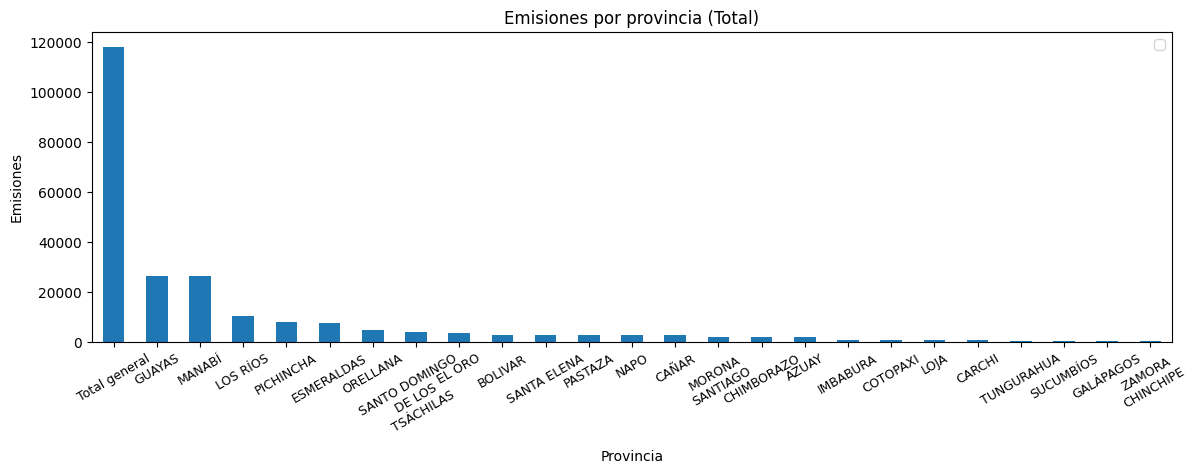

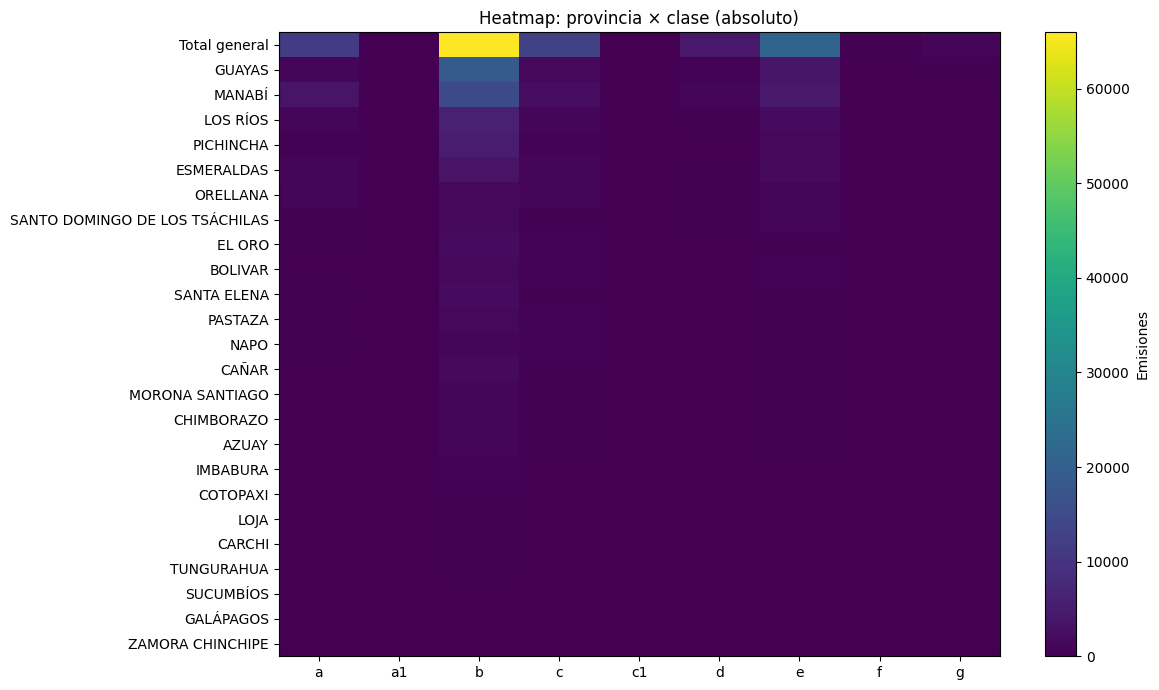

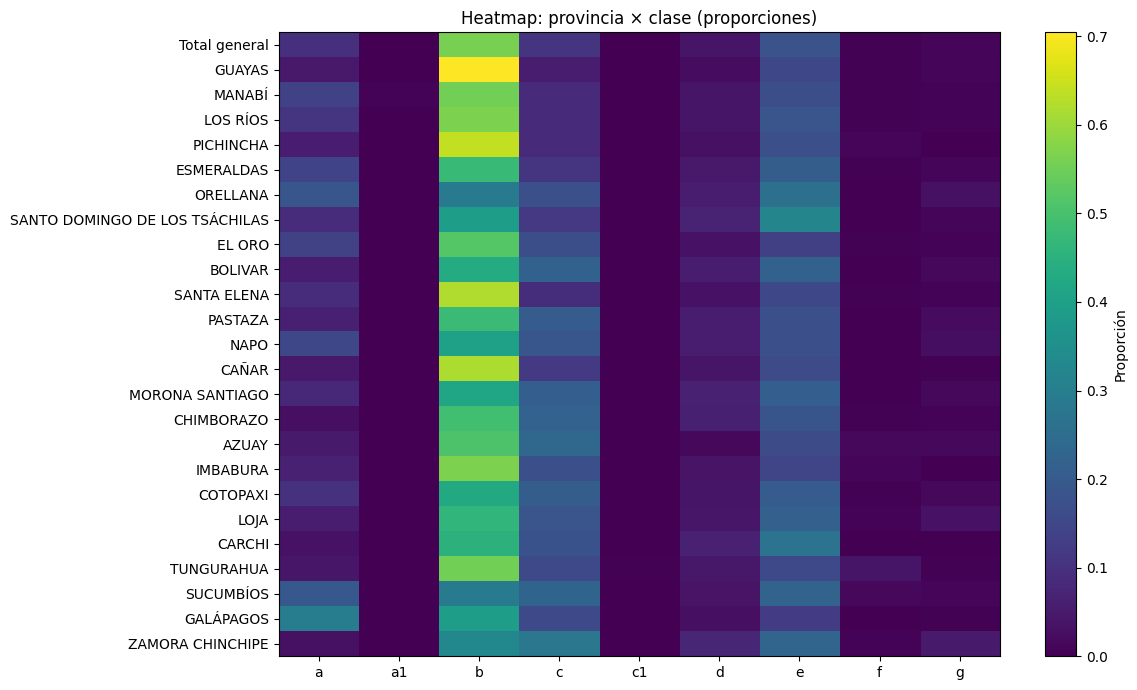

KPI (a) — Top 15 provincia×clase por Lift ponderado (prioridad operativa):


,unidad,clase,lift,var_pp,lift_pond
0,Total general,a,1.00,0.000,118000.000000
1,Total general,a1,1.00,0.000,118000.000000
2,Total general,b,1.00,0.000,118000.000000
3,Total general,c,1.00,0.000,118000.000000
4,Total general,c1,1.00,0.000,118000.000000
5,Total general,d,1.00,0.000,118000.000000
6,Total general,e,1.00,0.000,118000.000000
7,Total general,f,1.00,0.000,118000.000000
8,Total general,g,1.00,0.000,118000.000000
9,MANABÍ,a1,3.44,0.005,91303.167421


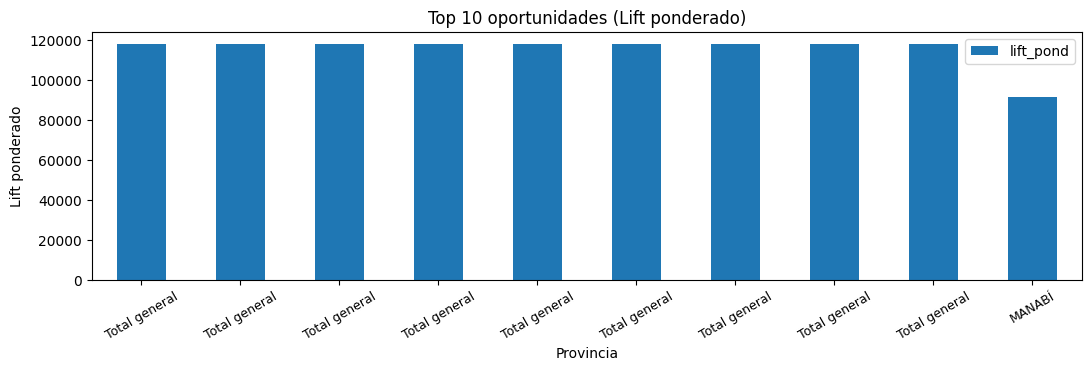


KPI (b) — Métricas del modelo (clasificación Top vs. no-Top)
Accuracy: 0.750 | Precision: 0.500 | Recall: 0.500 | F1: 0.500 | ROC-AUC: 0.750
Matriz de confusión:
 [[5 1]
 [1 1]]
Reporte:
               precision    recall  f1-score   support

           0      0.833     0.833     0.833         6
           1      0.500     0.500     0.500         2

    accuracy                          0.750         8
   macro avg      0.667     0.667     0.667         8
weighted avg      0.750     0.750     0.750         8


CV estratificada (media±std):


,accuracy,precision,recall,f1
mean,0.840,0.700,0.600,0.600
std,0.089,0.447,0.418,0.365



Focalización operativa — Top 12 provincias por prob_top:


,unidad,_total,prob_top,prop_a,prop_a1,prop_b,prop_c,prop_c1,prop_d,prop_e,prop_f,prop_g
0,MANABÍ,26546,0.888333,0.135877,0.006442,0.555602,0.082950,0.000565,0.039403,0.169027,0.003353,0.006781
1,Total general,118000,0.848333,0.096169,0.001873,0.558966,0.108754,0.000729,0.039119,0.179797,0.004127,0.010466
2,LOS RÍOS,10525,0.841667,0.108884,0.001330,0.566081,0.087601,0.000285,0.040570,0.184513,0.004181,0.006556
3,ESMERALDAS,7546,0.821667,0.142857,0.002650,0.477206,0.108534,0.000133,0.047972,0.207130,0.004241,0.009276
4,ORELLANA,4900,0.661667,0.188776,0.000000,0.292449,0.171020,0.000408,0.053061,0.261224,0.002245,0.030816
5,CAÑAR,2838,0.280000,0.048273,0.000705,0.618746,0.119803,0.000000,0.040521,0.164905,0.002114,0.004933
6,PICHINCHA,8139,0.221667,0.057378,0.000000,0.638776,0.084286,0.002580,0.031085,0.171520,0.012287,0.002089
7,TUNGURAHUA,517,0.220000,0.042553,0.000000,0.555126,0.156673,0.003868,0.044487,0.154739,0.038685,0.003868
8,GUAYAS,26631,0.208333,0.047501,0.000488,0.704292,0.056175,0.001164,0.023882,0.151740,0.002816,0.011941
9,COTOPAXI,998,0.188333,0.099198,0.001002,0.428858,0.206413,0.001002,0.039078,0.205411,0.005010,0.014028


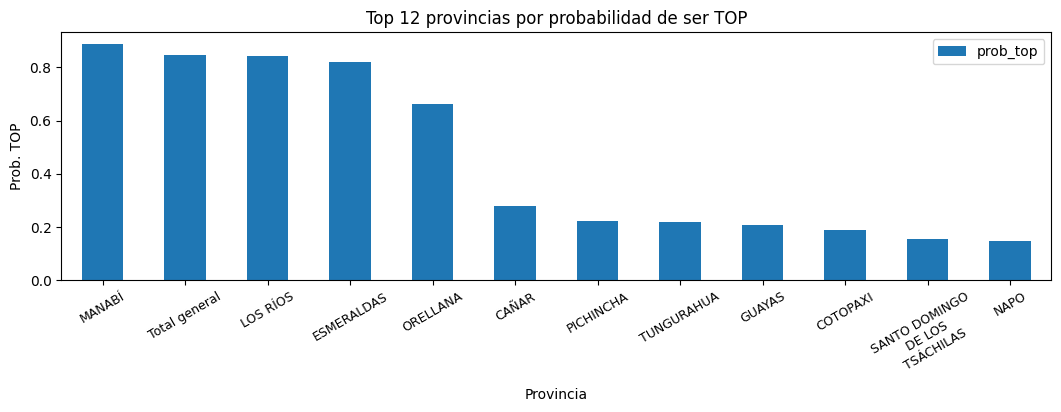


Archivos generados en ./export/:
 - focalizacion_prob_top.csv
 - heatmap_abs_valores.csv
 - heatmap_prop_valores.csv
 - kpi_lift_provincia_clase.csv
 - kpi_variacion_pp_provincia_clase.csv
 - provincia_totales_y_mezcla.csv


In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
from pathlib import Path 
from textwrap import wrap 
assert 'df_prov2' in globals() and 'prov_long' in globals(), "Ejecuta la Fase 3 primero." 
 
# ----------------------- 
# A. AUXILIARES / ENTRADAS 
# ----------------------- 
mix_cols    = [c for c in df_prov2.columns if c.startswith("prop_")] 
clases_cols = [c for c in ["a","a1","b","c","c1","d","e","f","g"] if c in df_prov2.columns] 
 
# Top real (Q3) con salvaguarda ≈25% o al menos 3 
score = df_prov2["_total"] 
q3    = score.quantile(0.75) 
es_top = (score >= q3).astype(int) 
min_pos = max(3, int(np.ceil(len(df_prov2)*0.25))) 
if es_top.sum() < min_pos: 
    idx_top = score.sort_values(ascending=False).head(min_pos).index 
    es_top = pd.Series(0, index=score.index); es_top.loc[idx_top] = 1 

# Probabilidades del modelo (si vienen de Fase 4C) 
prob_top = None 
if 'df_rank' in globals() and {"unidad","prob_top"}.issubset(df_rank.columns): 
    prob_top = df_rank.set_index("unidad")["prob_top"].reindex(df_prov2["unidad"]).values 
 
# Función para “envolver” etiquetas largas 
def wrap_labels(ax, width=12): 
    labs = [ "\n".join(wrap(str(t.get_text()), width)) for t in ax.get_xticklabels() ] 
    ax.set_xticklabels(labs) 
 
# ----------------------- 
# B. GRÁFICOS DESCRIPTIVOS 
# ----------------------- 
 
# B1) Barras: total por provincia 
fig, ax = plt.subplots(figsize=(12,5)) 
(df_prov2.sort_values("_total", ascending=False) 
        .plot(x="unidad", y="_total", kind="bar", ax=ax, 
              title="Emisiones por provincia (Total)")) 
ax.set_xlabel("Provincia"); ax.set_ylabel("Emisiones") 
ax.tick_params(axis='x', labelrotation=30, labelsize=9) 
wrap_labels(ax, 14) 
plt.subplots_adjust(bottom=0.28, top=0.90, left=0.08, right=0.98) 
plt.show() 
 
# B2) Heatmap: absoluto (provincia × clase) 
pivot_abs = (prov_long.pivot_table(index="unidad", columns="clase", 
                                   values="emisiones", aggfunc="sum", fill_value=0) 
                        .reindex(df_prov2["unidad"]))
fig, ax = plt.subplots(figsize=(12,7)) 
im = ax.imshow(pivot_abs.values, aspect="auto") 
fig.colorbar(im, ax=ax, label="Emisiones") 
ax.set_title("Heatmap: provincia × clase (absoluto)") 
ax.set_yticks(range(len(pivot_abs.index))); ax.set_yticklabels(pivot_abs.index) 
ax.set_xticks(range(len(pivot_abs.columns))); ax.set_xticklabels(pivot_abs.columns) 
plt.tight_layout(); plt.show() 
 
# B3) Heatmap: proporciones (mezcla por provincia) 
fila_suma   = pivot_abs.sum(axis=1).replace(0, np.nan) 
pivot_prop  = (pivot_abs.div(fila_suma, axis=0)).fillna(0) 
fig, ax = plt.subplots(figsize=(12,7)) 
im = ax.imshow(pivot_prop.values, aspect="auto") 
fig.colorbar(im, ax=ax, label="Proporción") 
ax.set_title("Heatmap: provincia × clase (proporciones)") 
ax.set_yticks(range(len(pivot_prop.index))); ax.set_yticklabels(pivot_prop.index) 
ax.set_xticks(range(len(pivot_prop.columns))); ax.set_xticklabels(pivot_prop.columns) 
plt.tight_layout(); plt.show() 
 
# --------------------------------------------------------- 
# C. KPI (a) — Lift y Variación por provincia×categoría 
# --------------------------------------------------------- 
# Definiciones: 
#  - prop_pais[c] = participación nacional de la clase c 
#  - prop_prov[p,c] = participación de la clase c dentro de la provincia p 
#  - LIFT[p,c] = prop_prov[p,c] / prop_pais[c] 
#  - VAR[p,c]  = prop_prov[p,c] - prop_pais[c]  (puntos porcentuales) 
prop_pais = (pivot_abs.sum(axis=0) / pivot_abs.values.sum())    # vector por clase 
lift      = pivot_prop.div(prop_pais, axis=1).replace([np.inf,-np.inf], np.nan).fillna(0.0)
var_pp    = (pivot_prop - prop_pais) 
 
# Tabla de “oportunidad” ponderando por tamaño provincial (total) 
op_score = (lift * df_prov2.set_index("unidad")["_total"].reindex(lift.index).values.reshape(-1,1)) 
top_lift = (op_score.stack() 
            .reset_index().rename(columns={"level_0":"unidad","level_1":"clase",0:"lift_pond"}) 
            .sort_values("lift_pond", ascending=False)) 
 
# Mostrar TOP 15 oportunidades por lift ponderado 
aux_prop_prov = pivot_prop.stack().rename("prop_prov").reset_index() 
aux_prop_pais = prop_pais.rename("prop_pais").reset_index().rename(columns={"index":"clase"}) 
top15 = (top_lift.head(15) 
         .merge(aux_prop_prov, on=["unidad","clase"]) 
         .merge(aux_prop_pais, on="clase")) 
top15["lift"]   = (top15["prop_prov"]/top15["prop_pais"]).round(2) 
top15["var_pp"] = (top15["prop_prov"]-top15["prop_pais"]).round(3) 
 
print("KPI (a) — Top 15 provincia×clase por Lift ponderado (prioridad operativa):") 
display(top15[["unidad","clase","lift","var_pp","lift_pond"]]) 
 
# Gráfico: Top 10 lift ponderado 
fig, ax = plt.subplots(figsize=(11,4)) 
top_lift.head(10).plot(x="unidad", y="lift_pond", kind="bar", ax=ax, 
                       title="Top 10 oportunidades (Lift ponderado)") 
ax.set_xlabel("Provincia"); ax.set_ylabel("Lift ponderado") 
ax.tick_params(axis='x', labelrotation=30, labelsize=9); wrap_labels(ax, 14) 
plt.subplots_adjust(bottom=0.28, top=0.90, left=0.08, right=0.98) 
plt.show()

# --------------------------------------------------------- 
# D. KPI (b) — Métricas del modelo y focalización operativa 
# --------------------------------------------------------- 
# Si no hay prob_top del paso 4C, entrenamos un modelo simple aquí. 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate 
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report, 
                             make_scorer) 
from sklearn.ensemble import RandomForestClassifier 
 
if not mix_cols: 
    # crear proporciones si hiciera falta 
    suma = df_prov2[clases_cols].sum(axis=1).replace(0, np.nan) 
    for c in clases_cols: 
        df_prov2[f"prop_{c}"] = (df_prov2[c]/suma).round(6) 
    mix_cols = [f"prop_{c}" for c in clases_cols] 
 
if prob_top is None: 
    y = es_top.copy() 
    X = df_prov2[mix_cols].fillna(0) 
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) 
    clf = RandomForestClassifier(n_estimators=600, class_weight="balanced", 
                                 random_state=42, n_jobs=-1) 
    clf.fit(Xtr, ytr) 
    proba_te = clf.predict_proba(Xte)[:,1] 
    # Umbral por ranking (evita “sin positivos”) 
    k_exp = max(1, int(round(ytr.mean()*len(yte)))) 
    order = np.argsort(-proba_te) 
    pred_rank = np.zeros_like(yte); pred_rank[order[:k_exp]] = 1

acc  = accuracy_score(yte, pred_rank)
prec = precision_score(yte, pred_rank, zero_division=0)
rec  = recall_score(yte, pred_rank, zero_division=0) 
f1   = f1_score(yte, pred_rank, zero_division=0) 
auc  = roc_auc_score(yte, proba_te) if len(np.unique(yte))==2 else float("nan") 
 
print("\nKPI (b) — Métricas del modelo (clasificación Top vs. no-Top)") 
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}") 
print("Matriz de confusión:\n", confusion_matrix(yte, pred_rank)) 
print("Reporte:\n", classification_report(yte, pred_rank, digits=3, zero_division=0)) 
 
    # CV estratificada 
n_splits = max(2, min(5, int(y.value_counts().min()))) 
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) 
scorers = {"accuracy": make_scorer(accuracy_score), 
               "precision": make_scorer(precision_score, zero_division=0), 
               "recall": make_scorer(recall_score, zero_division=0), 
               "f1": make_scorer(f1_score, zero_division=0)} 
res = cross_validate(clf, X, y, cv=cv, scoring=scorers, n_jobs=-1) 
print("\nCV estratificada (media±std):") 
display(pd.DataFrame({k:res[f'test_{k}'] for k in scorers}).agg(['mean','std']).round(3)) 
 
    # Ranking global para focalización 
prob_top = clf.predict_proba(X)[:,1] 
 
# Tabla de focalización: provincias priorizadas por prob_top 
df_focus = df_prov2.copy() 
df_focus["prob_top"] = prob_top
df_focus = df_focus.sort_values("prob_top", ascending=False).reset_index(drop=True) 
 
print("\nFocalización operativa — Top 12 provincias por prob_top:") 
display(df_focus[["unidad","_total","prob_top"] + mix_cols].head(12)) 
 
fig, ax = plt.subplots(figsize=(11,4)) 
df_focus.head(12).plot(x="unidad", y="prob_top", kind="bar", ax=ax, 
                       title="Top 12 provincias por probabilidad de ser TOP") 
ax.set_xlabel("Provincia"); ax.set_ylabel("Prob. TOP") 
ax.tick_params(axis='x', labelrotation=30, labelsize=9); wrap_labels(ax, 14) 
plt.subplots_adjust(bottom=0.28, top=0.90, left=0.08, right=0.98) 
plt.show() 
 
# ----------------------- 
# E. EXPORTABLES (CSV/PNG) 
# ----------------------- 
Path("export").mkdir(exist_ok=True) 
pivot_abs.to_csv("export/heatmap_abs_valores.csv") 
pivot_prop.to_csv("export/heatmap_prop_valores.csv") 
lift.to_csv("export/kpi_lift_provincia_clase.csv") 
var_pp.to_csv("export/kpi_variacion_pp_provincia_clase.csv") 
df_focus.to_csv("export/focalizacion_prob_top.csv", index=False) 
df_prov2.to_csv("export/provincia_totales_y_mezcla.csv", index=False) 
print("\nArchivos generados en ./export/:") 
for f in Path("export").iterdir(): 
    print(" -", f.name)